In [37]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import os


boning_df_resampled = pd.read_csv('boning_df_resampled.csv')
slicing_df_resampled = pd.read_csv('slicing_df_resampled.csv')

# **LSTM-CNN models evaluation**

In [18]:
models = [
    'models/boning_activity_recognition_LSTMCNN.keras', 
    'models/boning_sharpness_classification_LSTMCNN.keras',
    'models/slicing_activity_recognition_LSTMCNN.keras', 
    'models/slicing_sharpness_classification_LSTMCNN.keras'
]


def eval_activity_model(name, model, df):
    X = df.drop(columns=['sharpness', 'Label']).values
    y = df['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.fit_transform(X_test)

    time_steps = X_train_sc.shape[1]
    X_test_nn = X_test_sc.reshape(-1, time_steps, 1)

    print(f"\n===== Dataset: {name.upper()} =====")

    model = load_model(model)
    loss, acc = model.evaluate(X_test_nn, y_test, verbose=0)
    print(f"\nModel `{model}` → Test Loss: {loss:.4f}, Test Acc: {acc*100:.2f}%")

    y_pred_proba = model.predict(X_test_nn, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print("\nConfusion Matrix:\n")
    print(cm)
    print("\nClassification Report:\n")
    print(report)


def eval_sharpness_model(name, model, df):
    le = LabelEncoder()
    df['sharpness_enc'] = le.fit_transform(df['sharpness'])
    
    X = df.drop(columns=['sharpness', 'sharpness_enc', 'Label']).values
    y = df['sharpness_enc'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.fit_transform(X_test)

    time_steps = X_train_sc.shape[1]
    X_test_nn = X_test_sc.reshape(-1, time_steps, 1)

    print(f"\n===== Dataset: {name.upper()} =====")

    model = load_model(model)
    loss, acc = model.evaluate(X_test_nn, y_test, verbose=0)
    print(f"\nModel `{model}` → Test Loss: {loss:.4f}, Test Acc: {acc*100:.2f}%")

    y_pred_proba = model.predict(X_test_nn, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print("\nConfusion Matrix:\n")
    print(cm)
    print("\nClassification Report:\n")
    print(report)

In [14]:
eval_activity_model("boning_activity_recgonition", models[0], boning_df_resampled)


===== Dataset: BONING_ACTIVITY_RECGONITION =====

Model `<Functional name=functional, built=True>` → Test Loss: 0.2402, Test Acc: 91.28%
Confusion Matrix:
[[13822   470   488    29   600    34]
 [  257 12782    99    27   304    38]
 [  794   284 13346   126   865    26]
 [  104   280   122 14391   526    18]
 [  397   400   347   166 16252   104]
 [  192   281    77    42   436 12485]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     15443
           1       0.88      0.95      0.91     13507
           2       0.92      0.86      0.89     15441
           3       0.97      0.93      0.95     15441
           4       0.86      0.92      0.89     17666
           5       0.98      0.92      0.95     13513

    accuracy                           0.91     91011
   macro avg       0.92      0.91      0.91     91011
weighted avg       0.92      0.91      0.91     91011



In [19]:
eval_sharpness_model("boning_sharpness_classification", models[1], boning_df_resampled)


===== Dataset: BONING_SHARPNESS_CLASSIFICATION =====

Model `<Functional name=functional_2, built=True>` → Test Loss: 0.4865, Test Acc: 82.40%

Confusion Matrix:

[[ 9947   146    17     8    47   449    40   929]
 [  111  6613   149     2    56   554     0   238]
 [  109   102 10003   306    41   411     3   607]
 [   15     8   198  9214   366  1001     7   766]
 [    9     4     3   103  9368  1487    12   567]
 [   13     4     4     8   431 11353   251  1390]
 [   60     1     0     2   126   814  9355  1222]
 [  179     7     2     4   275  2112   244  9138]]

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     11583
           1       0.96      0.86      0.91      7723
           2       0.96      0.86      0.91     11582
           3       0.96      0.80      0.87     11575
           4       0.87      0.81      0.84     11553
           5       0.62      0.84      0.72     13454
           6       0.94

# **Random Forest Classification**

### Boning/Slicing classification

### Activity/Sharpness classification

# **Random Forest Evaluation**

In [42]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def sensor_analysis(df, label_col='Label', test_size=0.2, random_state=42):
    feature_cols = [c for c in df.columns if c != label_col]
    sensors = sorted({col.split('_', 1)[0] for col in feature_cols})

    results = {}

    X = df.drop(columns=[label_col, 'Unnamed: 0', 'sharpness']).values
    y = df[label_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    clf = RandomForestClassifier(n_estimators=10, random_state=random_state, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results['ALL'] = accuracy_score(y_test, y_pred)

    for sensor in sensors:
        drop_cols = [c for c in df.columns if c.startswith(sensor + '_')]
        df_reduced = df.drop(columns=drop_cols)

        Xr = df_reduced.drop(columns=[label_col]).values
        yr = df_reduced[label_col].values

        X_tr, X_te, y_tr, y_te = train_test_split(
            Xr, yr, test_size=test_size, stratify=yr, random_state=random_state
        )

        clf = RandomForestClassifier(n_estimators=10, random_state=random_state, n_jobs=-1)
        clf.fit(X_tr, y_tr)
        y_pr = clf.predict(X_te)
        results[sensor] = accuracy_score(y_te, y_pr)

    return results, ['ALL'] + sensors

def plot_sensor(results, sensor_list):
    accuracies = [results[s] for s in sensor_list]

    plt.figure(figsize=(12, 6))
    plt.bar(sensor_list, accuracies)
    plt.axhline(accuracies[0], color='red', linestyle='--', label='Baseline (ALL)')
    plt.xticks(rotation=90)
    plt.ylabel('Accuracy')
    plt.title('Leave One Sensor Out random Forest Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [38]:
results, sensor_list = sensor_analysis(boning_df_resampled)

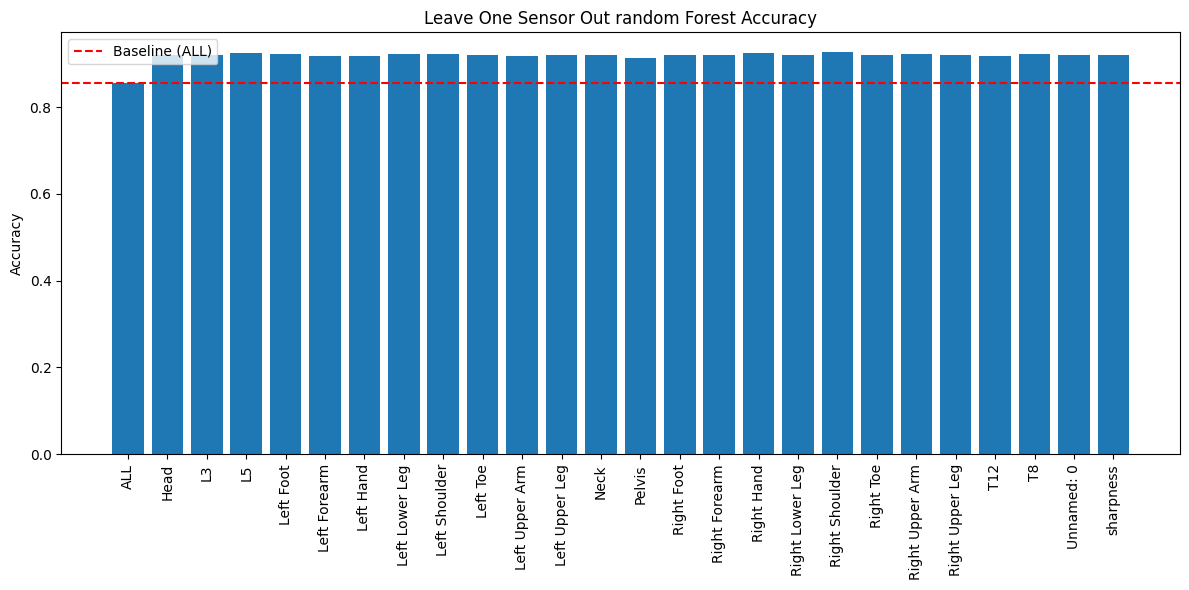

In [43]:
plot_sensor(results, sensor_list)